# **7) Model 5**

In [1]:
import os
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lit, pandas_udf
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Matplotlib created a temporary cache directory at /scratch/msawires1/job_40118173/matplotlib-acpdihs1 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Preprocessing for #5:

In [2]:
base_path = '../ialtamirano/raw_data/WESAD'

In [23]:
# survey for S10
subject_id = 'S10'
readme_path = os.path.join(base_path, subject_id, f'{subject_id}_readme.txt')

with open(readme_path, 'r') as f:
    content = f.read()
    print(content)


### Personal information ###
Age: 28
Height (cm): 178
Weight (kg): 76
Gender: male
Dominant hand: right

### Study pre-requisites ###
Did you drink coffee today? NO
Did you drink coffee within the last hour? NO
Did you do any sports today? NO
Are you a smoker? NO
Did you smoke within the last hour? NO
Do you feel ill today? NO

### Additional notes ###
-



In [24]:
# creating subject survey dictionary 
# gather all subjects 
exclude_subjects = {'S1', 'S12'}

all_fields = ['age', 'height (cm)', 'weight (kg)', 'gender_male',
              'gender_female', 'dominant_right', 'dominant_left',
              'coffee_today', 'coffee_last_hour', 'sports_today',
              'smoker', 'smoked_last_hour', 'ill_today']


                    
subject_folders = [folder for folder in os.listdir(base_path)
                   if folder.startswith('S') and 
                   os.path.isdir(os.path.join(base_path, folder)) 
                   and folder not in exclude_subjects]

subject_survey = {}

# access each subject readme.txt
for subject in subject_folders:
    subject_path = os.path.join(base_path, subject)
    readme_files = [file for file in os.listdir(subject_path) 
                    if file.lower().endswith('_readme.txt')]
    if not readme_files:
        print(f'No readme file founbd in {subject}')
        continue 
    readme_path = os.path.join(subject_path, readme_files[0])

# parse, encode, and store subject survey responses from README file into survey dictionary 
    survey = {}
    with open(readme_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if ':' in line:
                key, value = line.split(':', 1)
            elif '?' in line:
                key, value = line.rsplit("?", 1)
                key = key + '?'
            else:
                continue
            key = key.strip().lower()
            value = value.strip().lower()
            if key == 'age':
                survey['age'] = int(value) if value.isdigit() else None
            elif key == 'height (cm)':
                survey['height (cm)'] = int(value) if value.isdigit() else None
            elif key == 'weight (kg)':
                survey['weight (kg)'] = int(value) if value.isdigit() else None
            elif key == 'gender':
                survey['gender_male'] = 1 if value == 'male' else 0 
                survey['gender_female'] = 1 if value =='female' else 0 
            elif key == 'dominant hand':
                survey['dominant_right'] = 1 if value == 'right' else 0
                survey['dominant_left'] = 1 if value == 'left' else 0 
            elif key == 'did you drink coffee today?':
                survey['coffee_today'] = 1 if value == 'yes' else 0 
            elif key == 'did you drink coffee within the last hour?':
                survey['coffee_last_hour'] = 1 if value == 'yes' else 0 
            elif key == 'did you do any sports today?':
                survey['sports_today'] = 1 if value == 'yes' else 0 
            elif key == 'are you a smoker?':
                survey['smoker'] = 1 if value == 'yes' else 0
            elif key == 'did you smoke within the last hour?':
                survey['smoked_last_hour'] = 1 if value == 'yes' else 0 
            elif key == 'do you feel ill today?':
                survey['ill_today'] = 1 if value == 'yes' else 0

    for field in all_fields:
        if field not in survey:
            survey[field] = None
    subject_survey[subject] = survey

print(subject_survey)
        

{'S14': {'age': 27, 'height (cm)': 180, 'weight (kg)': 80, 'gender_male': 1, 'gender_female': 0, 'dominant_right': 1, 'dominant_left': 0, 'coffee_today': 0, 'coffee_last_hour': 0, 'sports_today': 0, 'smoker': 0, 'smoked_last_hour': 0, 'ill_today': 0}, 'S7': {'age': 28, 'height (cm)': 184, 'weight (kg)': 74, 'gender_male': 1, 'gender_female': 0, 'dominant_right': 1, 'dominant_left': 0, 'coffee_today': 0, 'coffee_last_hour': 0, 'sports_today': 1, 'smoker': 0, 'smoked_last_hour': 0, 'ill_today': 0}, 'S13': {'age': 28, 'height (cm)': 181, 'weight (kg)': 82, 'gender_male': 1, 'gender_female': 0, 'dominant_right': 1, 'dominant_left': 0, 'coffee_today': 0, 'coffee_last_hour': 0, 'sports_today': 0, 'smoker': 0, 'smoked_last_hour': 0, 'ill_today': 0}, 'S3': {'age': 27, 'height (cm)': 173, 'weight (kg)': 69, 'gender_male': 1, 'gender_female': 0, 'dominant_right': 1, 'dominant_left': 0, 'coffee_today': 0, 'coffee_last_hour': 0, 'sports_today': 0, 'smoker': 0, 'smoked_last_hour': 0, 'ill_today': 0

In [25]:
# creating a csv in pyspark 
spark = SparkSession.builder.getOrCreate()

all_fields = ['age', 'height (cm)', 'weight (kg)', 'gender_male',
              'gender_female', 'dominant_right', 'dominant_left',
              'coffee_today', 'coffee_last_hour', 'sports_today',
              'smoker', 'smoked_last_hour', 'ill_today']


rows = []
for subject, survey in subject_survey.items():
    row = {'subject': subject}
    for col in all_fields:
        row[col] = survey.get(col)
    rows.append(row)

# define scheme explicitly 
schema = StructType([
    StructField('subject', StringType(), False),
    StructField('age', IntegerType(), True),
    StructField('height (cm)', IntegerType(), True),
    StructField('weight (kg)', IntegerType(), True),
    StructField('gender_male', IntegerType(), True),
    StructField('gender_female', IntegerType(), True),
    StructField('dominant_right', IntegerType(), True),
    StructField('dominant_left', IntegerType(), True),
    StructField('coffee_today', IntegerType(), True),
    StructField('coffee_last_hour', IntegerType(), True),
    StructField('sports_today', IntegerType(), True),
    StructField('smoker', IntegerType(), True),
    StructField('smoked_last_hour', IntegerType(), True),
    StructField('ill_today', IntegerType(), True)])

df = spark.createDataFrame(rows, schema=schema)

df.printSchema()
df.show(truncate=False)

df.coalesce(1).write.csv('wesad_survey.csv', header=True, mode='overwrite')
    
    


root
 |-- subject: string (nullable = false)
 |-- age: integer (nullable = true)
 |-- height (cm): integer (nullable = true)
 |-- weight (kg): integer (nullable = true)
 |-- gender_male: integer (nullable = true)
 |-- gender_female: integer (nullable = true)
 |-- dominant_right: integer (nullable = true)
 |-- dominant_left: integer (nullable = true)
 |-- coffee_today: integer (nullable = true)
 |-- coffee_last_hour: integer (nullable = true)
 |-- sports_today: integer (nullable = true)
 |-- smoker: integer (nullable = true)
 |-- smoked_last_hour: integer (nullable = true)
 |-- ill_today: integer (nullable = true)

+-------+---+-----------+-----------+-----------+-------------+--------------+-------------+------------+----------------+------------+------+----------------+---------+
|subject|age|height (cm)|weight (kg)|gender_male|gender_female|dominant_right|dominant_left|coffee_today|coffee_last_hour|sports_today|smoker|smoked_last_hour|ill_today|
+-------+---+-----------+-----------+-

### Combining survey data and final dataframe data

In [27]:
data_dir = 'combined_pkl_csv'
chunk_size = 1000

modality_files = [
    'df_chest_acc.csv',
    'df_chest_ecg.csv',
    'df_chest_eda.csv',
    'df_chest_emg.csv',
    'df_chest_resp.csv',
    'df_chest_temp.csv',
    'df_wrist_acc.csv',
    'df_wrist_bvp.csv',
    'df_wrist_eda.csv',
    'df_wrist_temp.csv']

def chunk_and_compute_stats(df, modality_name, chunk_size=1000):
    grouped = df.groupby("subject")
    stats_rows = []

    for subject, group in grouped:
        group = group.sort_values("sample")
        signal_values = group.drop(columns=["subject", "label", "sample"]).values.flatten()
        labels = group["label"].values

        total_chunks = len(labels) // chunk_size
        if total_chunks == 0:
            continue

        signal_values = signal_values[:total_chunks * chunk_size].reshape(total_chunks, chunk_size)
        label_chunks = labels[:total_chunks * chunk_size].reshape(total_chunks, chunk_size)

        for i in range(total_chunks):
            window = signal_values[i]
            majority_label = mode(label_chunks[i], keepdims=False).mode

            stats_rows.append({
                "subject": subject,
                "modality": modality_name,
                "label": int(majority_label),
                "mean": np.mean(window),
                "std": np.std(window),
                "min": np.min(window),
                "max": np.max(window),
                "mode": float(mode(window, keepdims=False).mode),
                "median": np.median(window)
            })

    return pd.DataFrame(stats_rows)



In [28]:
# Final output DataFrame
all_chunks = []

for file in modality_files:
    file_path = os.path.join(data_dir, file)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        modality = file.replace("df_", "").replace(".csv", "")
        print(f"Processing {modality}...")
        chunked = chunk_and_compute_stats(df, modality)
        all_chunks.append(chunked)
    else:
        print(f"File not found: {file_path}")

# Combine all
final_df = pd.concat(all_chunks, ignore_index=True)
final_df.head()

Processing chest_acc...
Processing chest_ecg...
Processing chest_eda...
Processing chest_emg...
Processing chest_resp...
Processing chest_temp...
Processing wrist_acc...
Processing wrist_bvp...
Processing wrist_eda...
Processing wrist_temp...


,subject,modality,label,mean,std,min,max,mode,median
0,S10,chest_acc,1,0.260290,0.458175,-0.2144,0.9002,0.8898,0.0842
1,S10,chest_acc,1,0.258510,0.457711,-0.2256,0.8952,0.0846,0.0846
2,S10,chest_acc,1,0.259217,0.457695,-0.2198,0.8954,0.8882,0.0858
3,S10,chest_acc,1,0.255446,0.461250,-0.2312,0.8978,0.8882,0.0816
4,S10,chest_acc,1,0.251376,0.463228,-0.2438,0.8920,0.8846,0.0842


### Merging the 2 dataframes

In [30]:
survey_df= pd.read_csv('wesad_survey.csv/wesad_survey.csv')

merged_df = final_df.merge(survey_df, on='subject', how='left')

merged_df.to_csv('wesad_merged_df.csv', index=False)
print(merged_df.head())



  subject   modality  label      mean       std     min     max    mode  \
0     S10  chest_acc      1  0.260290  0.458175 -0.2144  0.9002  0.8898   
1     S10  chest_acc      1  0.258510  0.457711 -0.2256  0.8952  0.0846   
2     S10  chest_acc      1  0.259217  0.457695 -0.2198  0.8954  0.8882   
3     S10  chest_acc      1  0.255446  0.461250 -0.2312  0.8978  0.8882   
4     S10  chest_acc      1  0.251376  0.463228 -0.2438  0.8920  0.8846   

   median  age  ...  gender_male  gender_female  dominant_right  \
0  0.0842   28  ...            1              0               1   
1  0.0846   28  ...            1              0               1   
2  0.0858   28  ...            1              0               1   
3  0.0816   28  ...            1              0               1   
4  0.0842   28  ...            1              0               1   

   dominant_left  coffee_today  coffee_last_hour  sports_today  smoker  \
0              0             0                 0             0       0  

### Merge with PANAS too

In [3]:
import pandas as pd

# Load previously merged sensor+survey DataFrame
merged_df = pd.read_csv('wesad_merged_df.csv')

# Load all questionnaires (contains PANAS and more)
questionnaire_df = pd.read_csv('all_questionnaires.csv')

# Merge on subject/subject_id
merged_full_df = pd.merge(
    merged_df,
    questionnaire_df,
    left_on='subject',
    right_on='subject_id',
    how='left'
)

merged_full_df = merged_full_df.drop(columns=['subject_id'])


merged_full_df.to_csv('wesad_merged_with_questionnaires.csv', index=False)

print("Merged dataframe shape:", merged_full_df.shape)
print("Sample columns:", merged_full_df.columns.tolist())

Merged dataframe shape: (773832, 62)
Sample columns: ['subject', 'modality', 'label', 'mean', 'std', 'min', 'max', 'mode', 'median', 'age', 'height (cm)', 'weight (kg)', 'gender_male', 'gender_female', 'dominant_right', 'dominant_left', 'coffee_today', 'coffee_last_hour', 'sports_today', 'smoker', 'smoked_last_hour', 'ill_today', 'condition_id', 'condition_name', 'panas_active', 'panas_distressed', 'panas_interested', 'panas_inspired', 'panas_annoyed', 'panas_strong', 'panas_guilty', 'panas_scared', 'panas_hostile', 'panas_excited', 'panas_proud', 'panas_irritable', 'panas_enthusiastic', 'panas_ashamed', 'panas_alert', 'panas_nervous', 'panas_determined', 'panas_attentive', 'panas_jittery', 'panas_afraid', 'panas_stressed', 'panas_frustrated', 'panas_happy', 'panas_sad', 'stai_i_feel_at_ease', 'stai_i_feel_nervous', 'stai_i_am_jittery', 'stai_i_am_relaxed', 'stai_i_am_worried', 'stai_i_feel_pleasant', 'sam_valence', 'sam_arousal', 'sssq_committed_to_goals', 'sssq_wanted_to_succeed', 's

### Random Forest: Senors + ALL Questionnaires

In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('wesad_merged_with_questionnaires.csv')

# target and feature columns 
target_col = 'label'
non_feature_cols = [
    'subject', 'modality', 'label', 'stress_binary', 'condition_id', 'condition_name'
]
feature_cols = [col for col in df.columns if col not in non_feature_cols]

# get only numeric columns and fill in missing values with median 
X = df[feature_cols].select_dtypes(include='number')
X = X.fillna(X.median())
y = df[target_col]

# test:20%, train:80%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Random Forest 
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=25,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1)
rf.fit(X_train, y_train)

# Evaluate on training data
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_accuracy)


# Evaluate on test data
y_test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('\nTest accuracy:', test_accuracy)



Training accuracy: 0.9113970261604193

Test accuracy: 0.7821499415250021


### Post-model analysis

Matplotlib created a temporary cache directory at /scratch/tsanchez/job_40043468/matplotlib-757d2i2w because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


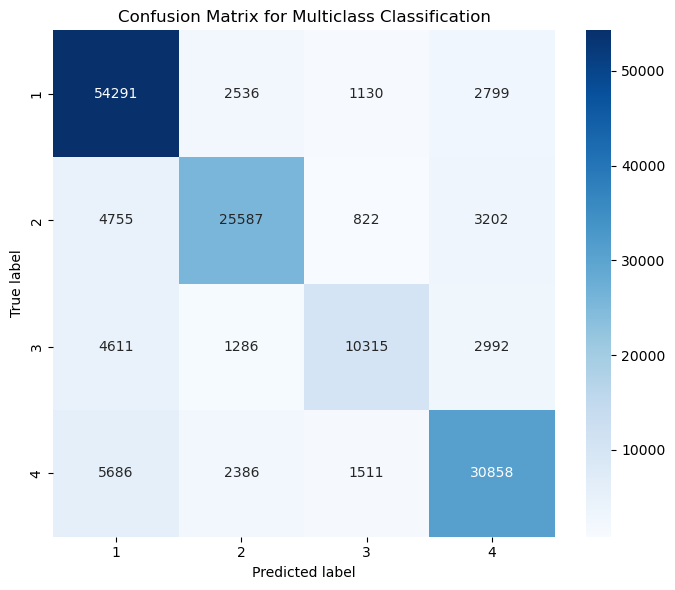

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Multiclass Classification')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

           1     0.7829    0.8936    0.8346     60756
           2     0.8047    0.7445    0.7735     34366
           3     0.7487    0.5371    0.6255     19204
           4     0.7743    0.7630    0.7686     40441

    accuracy                         0.7821    154767
   macro avg     0.7777    0.7346    0.7506    154767
weighted avg     0.7813    0.7821    0.7779    154767



/scratch/tsanchez/job_40043468/ipykernel_2240337/3219460029.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names, palette='pastel')


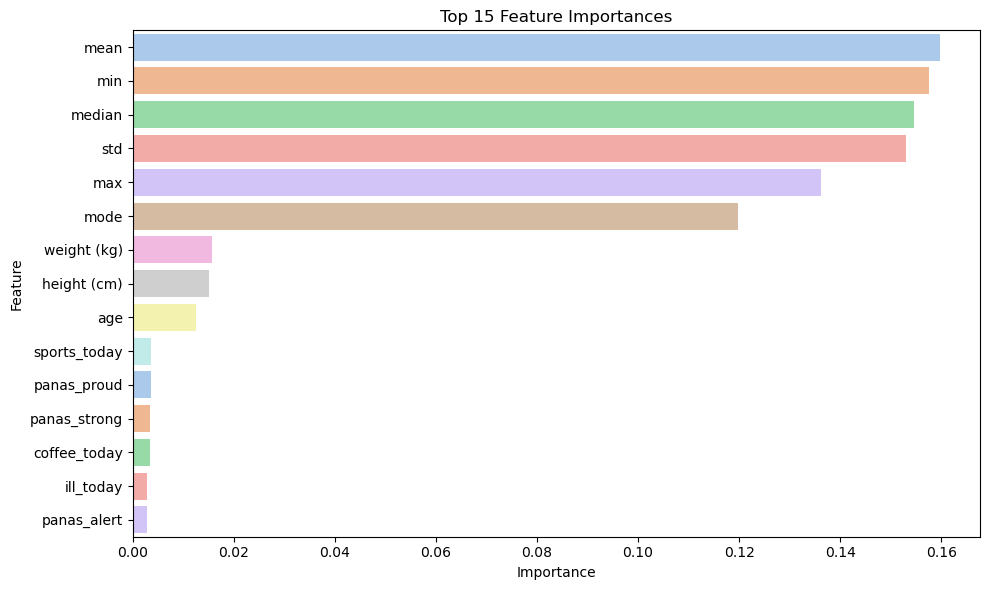

In [14]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:][::-1]
feature_names = X_train.columns[indices]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=feature_names, palette='pastel')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()